# A2 assignment's notebook for Complex Networks at URV 2025

## Authors:

- Lobo Santos, Antonio
-  Kasa, Andras


## Part 1: Characterization of the community structure of networks with block structure

In [9]:
# Import libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import infomap as im
from collections import defaultdict
import time
from sklearn.metrics import normalized_mutual_info_score
from collections import Counter
import os
from math import log
import itertools
import concurrent
from utils import *
# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)


#### Define SBM Parameters and Generate the Network

We first define our SBM parameters. The network is divided into 5 blocks of equal size. The intra-block connection probability (prr) is set to an example value of 0.16 and the inter-block connection probability (prs) is 0.02. A probability matrix is then built where diagonal entries correspond to `prr` and off-diagonals to `prs`.


In [2]:
# Define parameters
N = 300                   # Total number of nodes
nblocks = 5               # Number of blocks
block_size = N // nblocks # Equal block sizes
prr = 0.16                # Intra-block probability
prs = 0.02                # Inter-block probability

# Create list of block sizes
sizes = [block_size] * nblocks

# Create the probability matrix for SBM
p_matrix = [[prr if i == j else prs for j in range(nblocks)] for i in range(nblocks)]

# Print the parameters for verification
print("SBM Parameters:")
print(f"Total nodes: {N}")
print(f"Blocks: {nblocks}")
print(f"Block sizes: {sizes}")
print(f"Intra-block probability (prr): {prr}")
print(f"Inter-block probability (prs): {prs}")

SBM Parameters:
Total nodes: 300
Blocks: 5
Block sizes: [60, 60, 60, 60, 60]
Intra-block probability (prr): 0.16
Inter-block probability (prs): 0.02


### Generate the Synthetic SBM Network

We now use the `networkx.stochastic_block_model` function to generate our synthetic network with the specified SBM parameters.


In [3]:
def create_sbm_graph(N=300, nblocks=5, prr=0.16, prs=0.02, seed=None, save_pajek=False):
    """
    Generate a synthetic network using the stochastic block model (SBM) and return the NetworkX graph.
    
    Parameters:
    -----------
    N : int
        Total number of nodes.
    nblocks : int
        Number of blocks (communities). Assumes equal block sizes.
    prr : float
        Intra-block connection probability.
    prs : float
        Inter-block connection probability.
    seed : int or None
        Random seed for reproducibility.
    save_pajek : bool
        If True, the graph will be saved in Pajek format with a filename based on the parameters.
    
    Returns:
    --------
    G : networkx.Graph
        The generated SBM network.
    """
    block_size = N // nblocks
    sizes = [block_size] * nblocks

    # Create the probability matrix: prr for intra-block, prs for inter-block.
    p_matrix = [[prr if i == j else prs for j in range(nblocks)] for i in range(nblocks)]

    # Generate the SBM network using NetworkX.
    G = nx.stochastic_block_model(sizes, p_matrix, seed=seed)

    # Optionally, save the network in Pajek format.
    if save_pajek:
        filename = f"synthetic_network_N_{N}_blocks_{nblocks}_prr_{prr}_prs_{prs}.net"
        nx.write_pajek(G, filename)
    
    return G

G = create_sbm_graph(N, nblocks, prr, prs, seed=SEED, save_pajek=True)

# Print basic information about the generated network
print("Generated SBM Network:")
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Generated SBM Network:
Number of nodes: 300
Number of edges: 2182


c:\Users\Usuario\anaconda3\envs\CN\lib\site-packages\networkx\readwrite\pajek.py:75: UserWarning: Node attribute block is not processed. Non-string attribute.
  warnings.warn(


In [4]:
def plot_Adjacency_matrix(G, nblocks, title_suffix=""):
    # Get the adjacency matrix of G
    A = nx.to_numpy_array(G)

    plt.figure(figsize=(10, 10))
    plt.imshow(A, interpolation='none', cmap='Greys')
    plt.title("Adjacency Matrix of the SBM Network " + title_suffix)
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")

    num_nodes = G.number_of_nodes()
    block_size = num_nodes // nblocks

    # Draw boundary lines to separate groups
    for i in range(1, nblocks):
        pos = i * block_size
        plt.axhline(pos, color='red', linestyle='--', linewidth=0.5)
        plt.axvline(pos, color='red', linestyle='--', linewidth=0.5)

    # Annotate the number of intra-block connections (within each block)
    for i in range(nblocks):
        start = i * block_size
        end = (i + 1) * block_size
        # Extract block adjacency matrix
        block_A = A[start:end, start:end]
        # Count edges in this block (each edge is counted twice in the full matrix for undirected graphs)
        count = int(np.sum(block_A) / 2)
        center = start + block_size / 2
        plt.text(center, center, f'{count}', color='blue', fontsize=12,
                 ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Annotate the number of inter-block connections (between different blocks)
    for i in range(nblocks):
        for j in range(i + 1, nblocks):
            start_i = i * block_size
            end_i = (i + 1) * block_size
            start_j = j * block_size
            end_j = (j + 1) * block_size
            # Extract the submatrix corresponding to connections between block i and block j
            inter_block_A = A[start_i:end_i, start_j:end_j]
            # Count the number of inter-block connections (no need to divide by 2 since these are off-diagonal)
            count_inter = int(np.sum(inter_block_A))
            # Determine the center position for the annotation in the inter-block region
            center_x = (start_j + end_j) / 2
            center_y = (start_i + end_i) / 2
            plt.text(center_x, center_y, f'{count_inter}', color='green', fontsize=12,
                     ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.colorbar(label="Edge Weight")
    plt.tight_layout()
    plt.show()


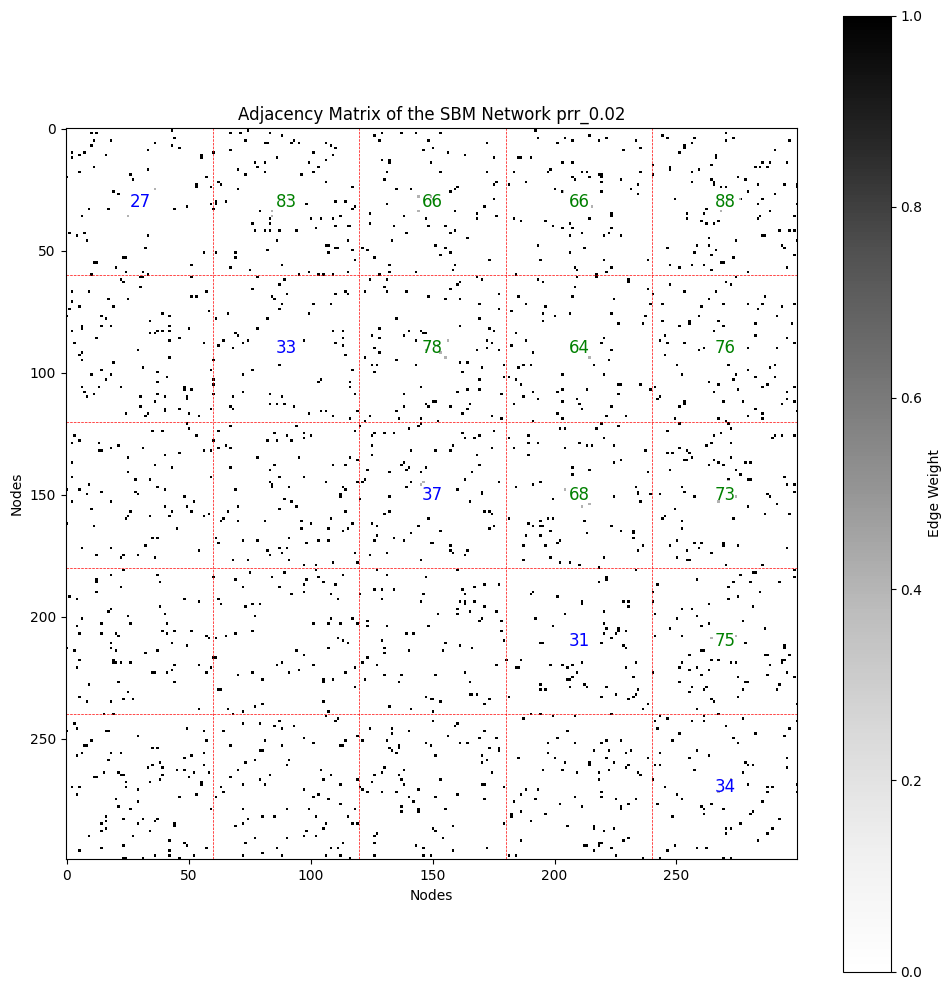

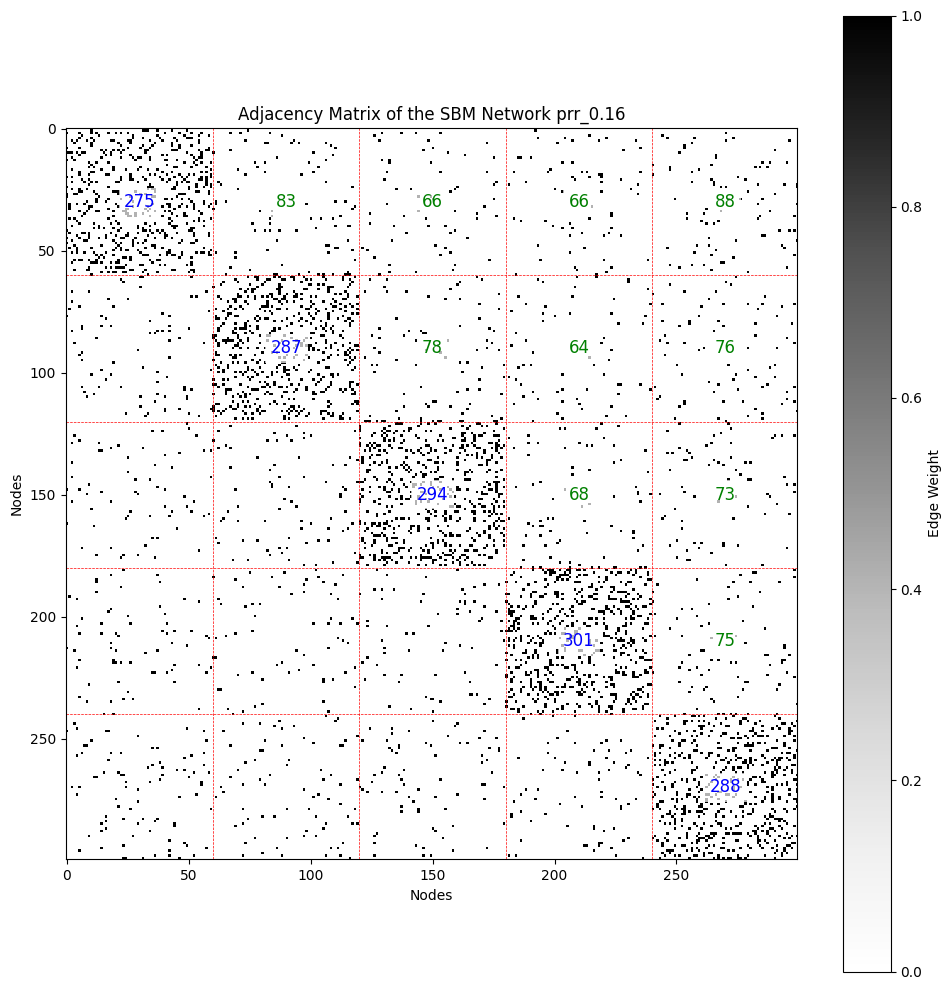

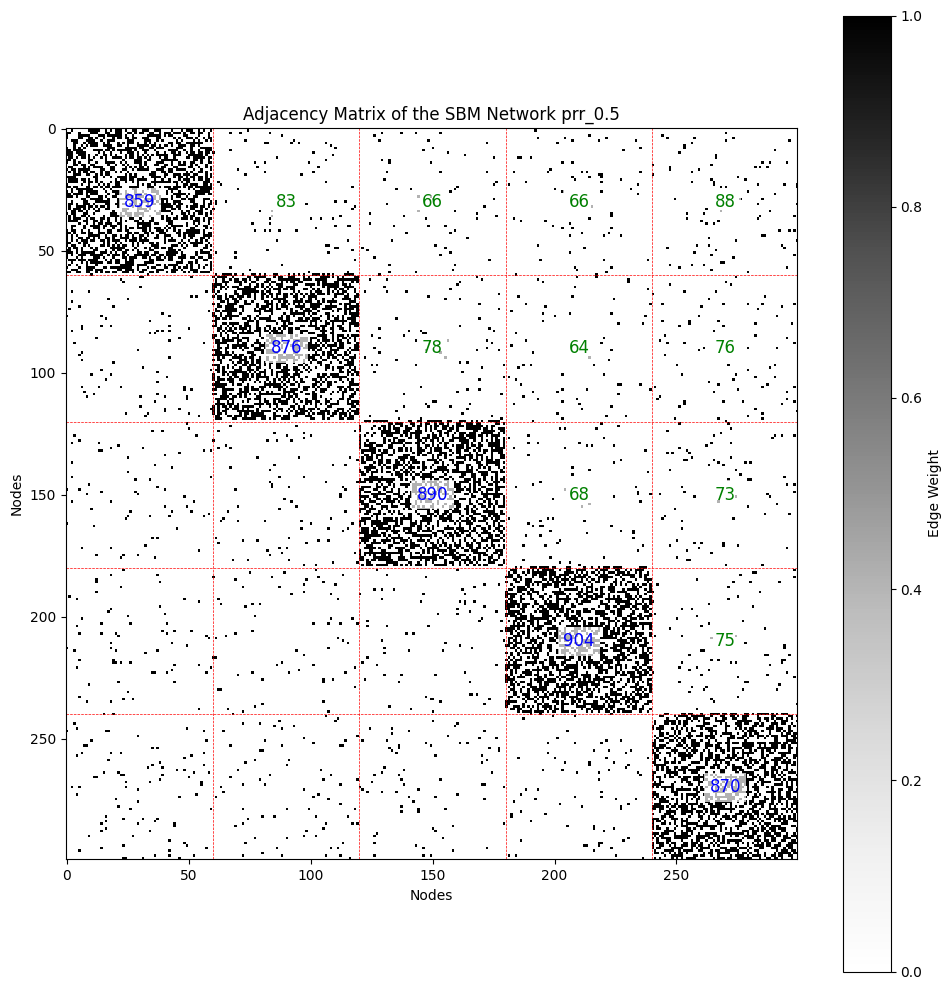

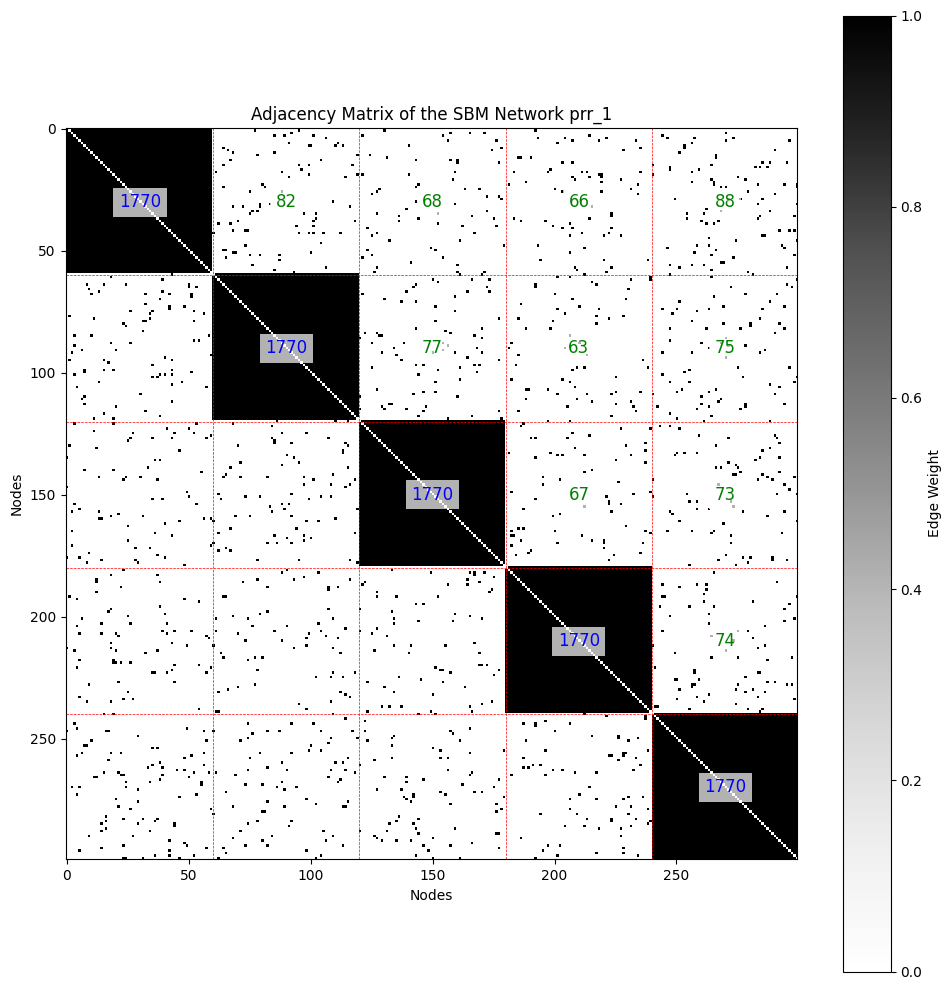

In [6]:

for prr_i in [0.02, 0.16, 0.5, 1]:
    G = create_sbm_graph(N, nblocks, prr_i, prs, seed=SEED, save_pajek=True)
    plot_Adjacency_matrix(G, nblocks, title_suffix=f"prr_{prr_i}")

### Finding Communities
In this section we will focus on identifying the communities on the previously generated graphs. First we will compute all communities using the following algorithms:

1. Infomap
2. Louvain
3. Greedy Modularity 
4. Girvan-Newman method (constranied and unconstrained)

In [12]:



def infomap_to_networkx_communities(mapping, partition):
    """
    Convert Infomap partition to list of sets (NetworkX communities format).
    
    Args:
        mapping (dict): Mapping from NetworkX nodes to Infomap nodes.
        partition (dict): Infomap partition (node -> module).
        
    Returns:
        list: List of sets where each set is a community.
    """
    # Convert partition to dict keyed by the original node names
    reverse_mapping = {v: k for k, v in mapping.items()}
    original_partition = {reverse_mapping[node]: module for node, module in partition.items()}
    
    # Group nodes by community
    communities = {}
    for node, community_id in original_partition.items():
        if community_id not in communities:
            communities[community_id] = set()
        communities[community_id].add(node)
    
    # Convert dict to list of sets
    return list(communities.values())

# 1. Define the GN functions
def girvan_newman_constrained(G, k=10):
    """Girvan-Newman to find exactly k communities and returning the one with greater modularity"""
    comp = nx.community.girvan_newman(G)
    limited = itertools.takewhile(lambda c: len(c) <= k, comp)
    maximum_modularity_community = max(limited, key=lambda c: nx.community.modularity(G, c))
    return maximum_modularity_community


def get_all_communities_parallel(G, block_size, nblocks, silent_infomap=True, max_workers=None):
    """
    Get communities with either constrained or unconstrained Girvan-Newman using thread-based parallelization
    """
    # Define all the community detection functions inline to avoid serialization issues
    def run_infomap():
        import infomap as im
        infomap_wrapper = im.Infomap(silent=silent_infomap)
        mapping = infomap_wrapper.add_networkx_graph(G)
        infomap_wrapper.run()
        infomap_partition = infomap_wrapper.get_modules()
        return infomap_to_networkx_communities(mapping, infomap_partition)
    
    def run_louvain():
        return nx.community.louvain_communities(G)
    
    def run_greedy():
        return nx.community.greedy_modularity_communities(G)
    
    def run_girvan_newman_constrained():
        return girvan_newman_constrained(G)
    
    
    def run_golden_standard():
        return [set(range(i * block_size, (i + 1) * block_size)) for i in range(nblocks)]
    
    # Use ThreadPoolExecutor instead of ProcessPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Create a dictionary mapping names to functions
        tasks = {
            "infomap": run_infomap,
            "louvain": run_louvain,
            "greedy": run_greedy,
            # "girvan_newmanc": run_girvan_newman_constrained,
            "golden_standard": run_golden_standard
        }
        
        # # Submit all tasks
        futures = {name: executor.submit(func) for name, func in tasks.items()}
        
        # Collect results as they complete
        results = {}
        for name, future in futures.items():
            try:
                results[name] = future.result()
            except Exception as exc:
                print(f'{name} generated an exception: {exc}')
                results[name] = None
        print("All communities completed.")
        return results


In the code below, we tested the result of the get_communities function. It takes at least 10 minutes to run, so you might want to avoid using it.


In [13]:
communities = get_all_communities_parallel(G, block_size, nblocks)
print (communities) 


: 

: 

In [ ]:
def analyze_specific_prr_values(prr_values=[0.02, 0.16, 1.00], seed=SEED):
    """
    Run community detection for specific prr values and save results as Pajek files.
    
    Args:
        prr_values: List of prr values to analyze
        seed: Random seed for reproducibility
    """
    print(f"Analyzing networks at specific prr values: {prr_values}")
    
    # Function to write communities in Pajek .clu format
    def write_pajek_communities(communities, filename):
        """Write communities to a Pajek .clu file"""
        # Flatten communities into a mapping from node to community ID
        node_to_comm = {}
        for comm_id, comm in enumerate(communities):
            for node in comm:
                node_to_comm[node] = comm_id + 1  # Pajek uses 1-based indexing
        
        # Get total number of nodes
        num_nodes = len(node_to_comm)
        
        # Write to file
        with open(filename, 'w') as f:
            f.write(f"*Vertices {num_nodes}\n")
            for node in range(num_nodes):
                # Use community ID if node exists, otherwise 1
                comm_id = node_to_comm.get(node, 1)
                f.write(f"{comm_id}\n")
        
        print(f"  Communities saved to {filename}")
    
    for prr in prr_values:
        print(f"\nProcessing network with prr = {prr:.2f}")
        
        # Create the graph
        G = create_sbm_graph(N, nblocks, prr, prs, seed=seed, save_pajek=False)
        
        # Save network
        net_filename = f"network_prr_{prr:.2f}.net"
        nx.write_pajek(G, net_filename)
        print(f"  Network saved as {net_filename}")
        
        # Run community detection
        communities = get_all_communities_parallel(G, block_size, nblocks, silent_infomap=True)
        
        # Save each algorithm's communities as separate .clu files
        for method, comm_list in communities.items():
            clu_filename = f"{method}_prr_{prr:.2f}.clu"
            write_pajek_communities(comm_list, clu_filename)
        
        # Print community information
        print("\nCommunity detection results:")
        for method, comm_list in communities.items():
            print(f"\n  {method}: {len(comm_list)} communities")
            for i, comm in enumerate(comm_list):
                # Print shortened version if community is large
                if len(comm) > 10:
                    comm_sample = list(sorted(comm))[:5] + ['...'] + list(sorted(comm))[-5:]
                    print(f"    Community {i+1}: {comm_sample} (size: {len(comm)})")
                else:
                    print(f"    Community {i+1}: {sorted(comm)}")
    
    print("\nAnalysis complete. Networks and communities saved as Pajek files.")

Using this function, we can create all .clu files and use them for plotting purposes. In the following steps, we used the functions provided on the GitHub page:
https://github.com/joaquincabezas/networkx_pajek_util/tree/master


In [8]:
analyze_specific_prr_values()

Analyzing networks at specific prr values: [0.02, 0.16, 1.0]

Processing network with prr = 0.02
  Network saved as network_prr_0.02.net
  Communities saved to infomap_prr_0.02.clu
  Communities saved to louvain_prr_0.02.clu
  Communities saved to greedy_prr_0.02.clu
  Communities saved to girvan_newmanc_prr_0.02.clu
  Communities saved to girvan_newmanunc_prr_0.02.clu
  Communities saved to golden_standard_prr_0.02.clu

Community detection results:

  infomap: 26 communities
    Community 1: [0, 3, 17, 20, 56, '...', 237, 247, 263, 275, 276] (size: 18)
    Community 2: [1, 74, 125, 187, 192, 201, 266]
    Community 3: [2, 28, 67, 71, 114, '...', 146, 152, 267, 287, 296] (size: 14)
    Community 4: [4, 19, 26, 38, 43, '...', 249, 268, 273, 279, 290] (size: 29)
    Community 5: [5, 6, 11, 12, 16, '...', 245, 282, 283, 286, 288] (size: 26)
    Community 6: [7, 8, 10, 60, 105, 217, 235, 269]
    Community 7: [9, 42, 81, 94, 153, '...', 169, 194, 212, 228, 248] (size: 11)
    Community 8: 

Let us move the community files to the SBM subfolder

In [12]:
import os
import shutil

def move_files_to_sbm_folder():
    """
    Move all Pajek files (.net and .clu) created by analyze_specific_prr_values
    to a subfolder named 'SBM'.
    """
    # Create SBM folder if it doesn't exist
    if not os.path.exists('SBM'):
        os.makedirs('SBM')
        print("Created SBM folder")
    
    # Find all .net and .clu files in the current directory
    pajek_files = []
    for file in os.listdir('.'):
        if file.endswith('.net') or file.endswith('.clu'):
            pajek_files.append(file)
    
    # Move files to SBM folder
    moved_count = 0
    for file in pajek_files:
        source = file
        destination = os.path.join('SBM', file)
        try:
            shutil.move(source, destination)
            moved_count += 1
            print(f"Moved: {file} → SBM/{file}")
        except Exception as e:
            print(f"Error moving {file}: {e}")
    
    print(f"\nMoved {moved_count} files to the SBM folder")

move_files_to_sbm_folder()

Created SBM folder
Moved: girvan_newmanc_prr_0.02.clu → SBM/girvan_newmanc_prr_0.02.clu
Moved: girvan_newmanc_prr_0.16.clu → SBM/girvan_newmanc_prr_0.16.clu
Moved: girvan_newmanc_prr_1.00.clu → SBM/girvan_newmanc_prr_1.00.clu
Moved: girvan_newmanunc_prr_0.02.clu → SBM/girvan_newmanunc_prr_0.02.clu
Moved: girvan_newmanunc_prr_0.16.clu → SBM/girvan_newmanunc_prr_0.16.clu
Moved: girvan_newmanunc_prr_1.00.clu → SBM/girvan_newmanunc_prr_1.00.clu
Moved: golden_standard_prr_0.02.clu → SBM/golden_standard_prr_0.02.clu
Moved: golden_standard_prr_0.16.clu → SBM/golden_standard_prr_0.16.clu
Moved: golden_standard_prr_1.00.clu → SBM/golden_standard_prr_1.00.clu
Moved: greedy_prr_0.02.clu → SBM/greedy_prr_0.02.clu
Moved: greedy_prr_0.16.clu → SBM/greedy_prr_0.16.clu
Moved: greedy_prr_1.00.clu → SBM/greedy_prr_1.00.clu
Moved: infomap_prr_0.02.clu → SBM/infomap_prr_0.02.clu
Moved: infomap_prr_0.16.clu → SBM/infomap_prr_0.16.clu
Moved: infomap_prr_1.00.clu → SBM/infomap_prr_1.00.clu
Moved: louvain_prr

In [19]:
def set_color_nodes(communities, G):
    colors = plt.cm.jet(np.linspace(0, 1, len(communities)))
    community_node = {}
    count_community = 0

    for community in communities:
        for node in community:
            community_node[node] = count_community
        count_community = count_community + 1

    color_nodes = []
    for node in G.nodes():
        color_nodes.append(colors[community_node[node]])
    
    return color_nodes

import os
from utils import read_pajek_communities

def plot_prr_comparison(G, communities_dict, positions, method=""):
    prr_values = sorted(communities_dict.keys())
    num_prr = len(prr_values)
    
    fig, axes = plt.subplots(1, num_prr, figsize=(5 * num_prr, 5))
    
    if num_prr == 1:
        axes = [axes]
    
    for ax, prr in zip(axes, prr_values):
        communities = communities_dict[prr]
        color_nodes = set_color_nodes(communities, G)
        nx.draw(
            G, 
            node_color=color_nodes, 
            pos=positions, 
            with_labels=False, 
            node_size=20, 
            alpha=0.8, 
            edge_color="gray", 
            ax=ax
        )
        ax.set_title(f"prr = {prr}")
        ax.axis("off")
    
    fig.suptitle(f"Communities for different prr values using {method}", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{method}_comparison.png", dpi=300)
    plt.show()

def load_communities_from_files(folder="SBM"):
    communities_dict = {}
    
    for filename in os.listdir(folder):
        if filename.endswith(".clu"):
            parts = filename.split("_")
            method_parts = []
            prr = None
            
            for i, part in enumerate(parts):
                if part == "prr" and i+1 < len(parts):
                    prr = float(parts[i+1].replace(".clu", ""))
                elif part != "prr" and "prr" not in parts[:i]:
                    method_parts.append(part)
            
            method = "_".join(method_parts)
            
            if prr is not None and method:
                communities = read_pajek_communities(os.path.join(folder, filename))
                
                if method not in communities_dict:
                    communities_dict[method] = {}
                
                communities_dict[method][prr] = communities
    
    return communities_dict

Plotting communities for method: girvan_newmanc


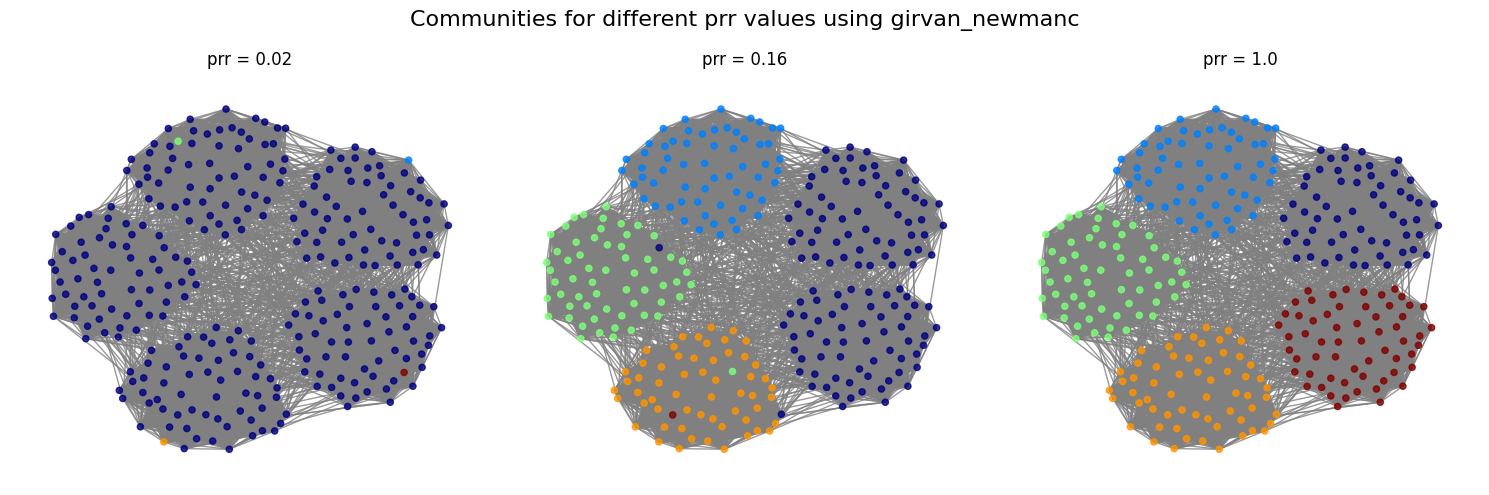

Plotting communities for method: girvan_newmanunc


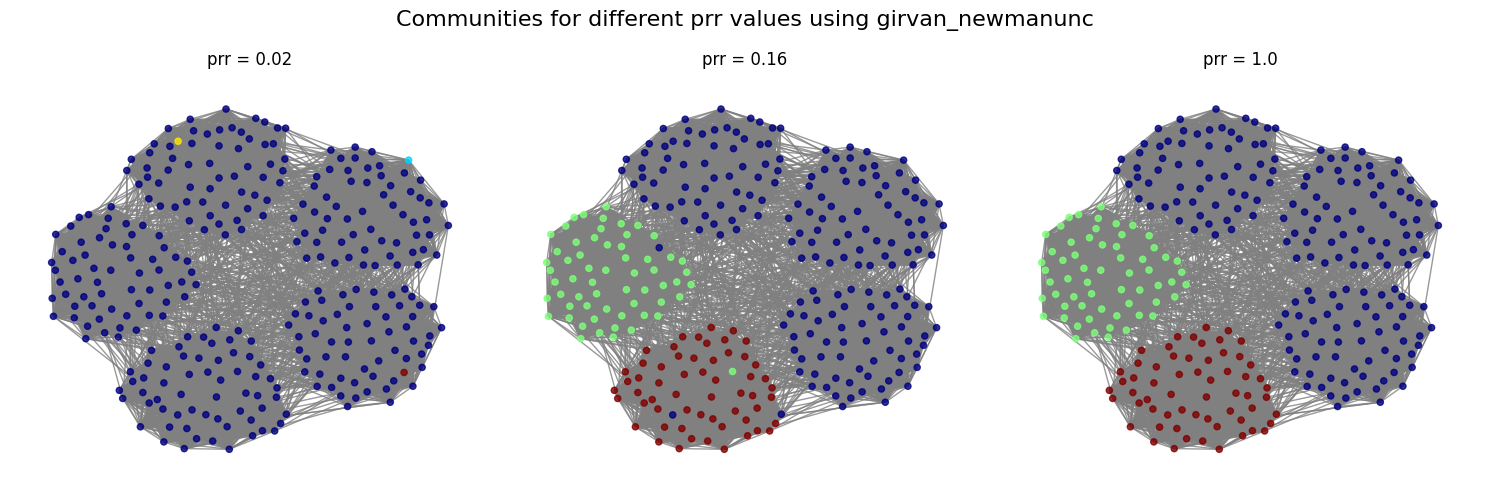

Plotting communities for method: golden_standard


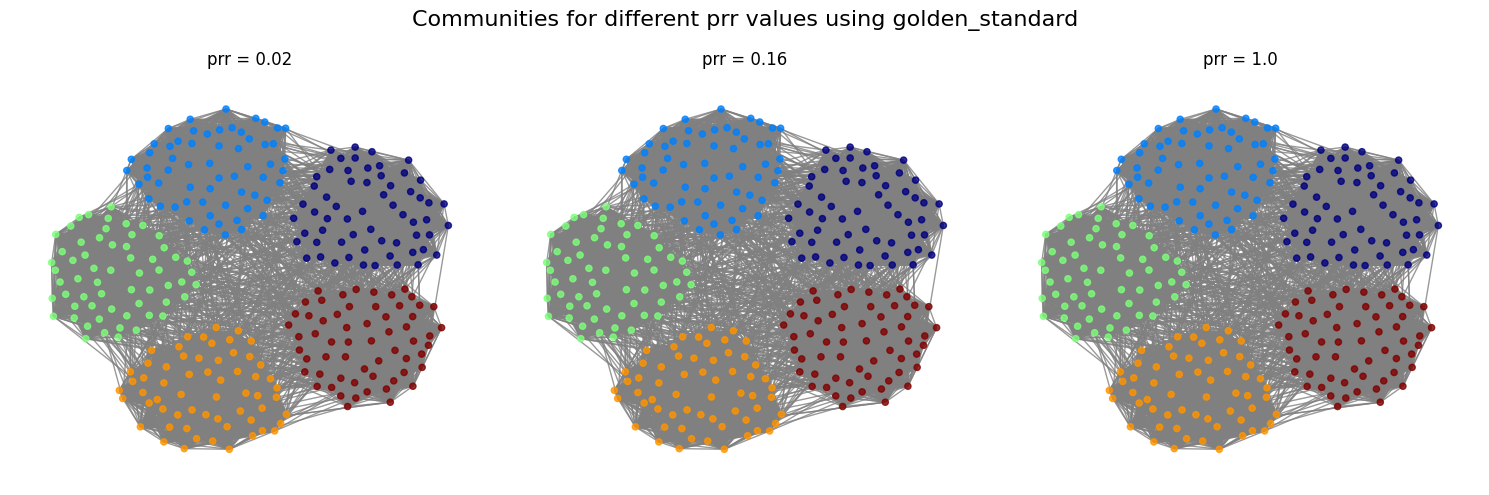

Plotting communities for method: greedy


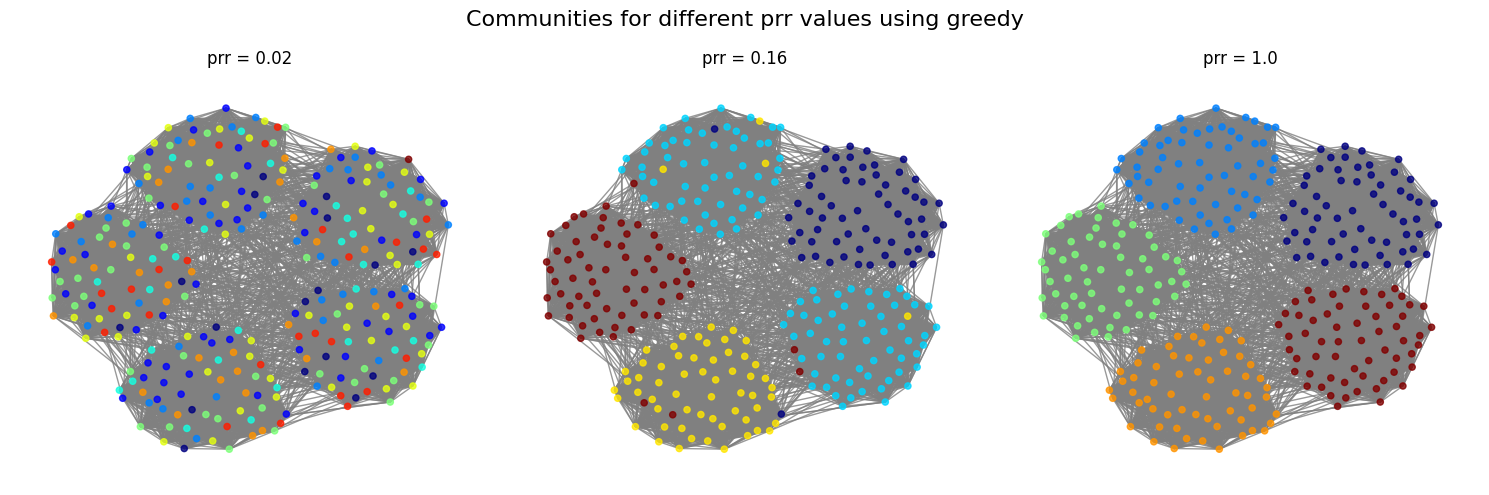

Plotting communities for method: infomap


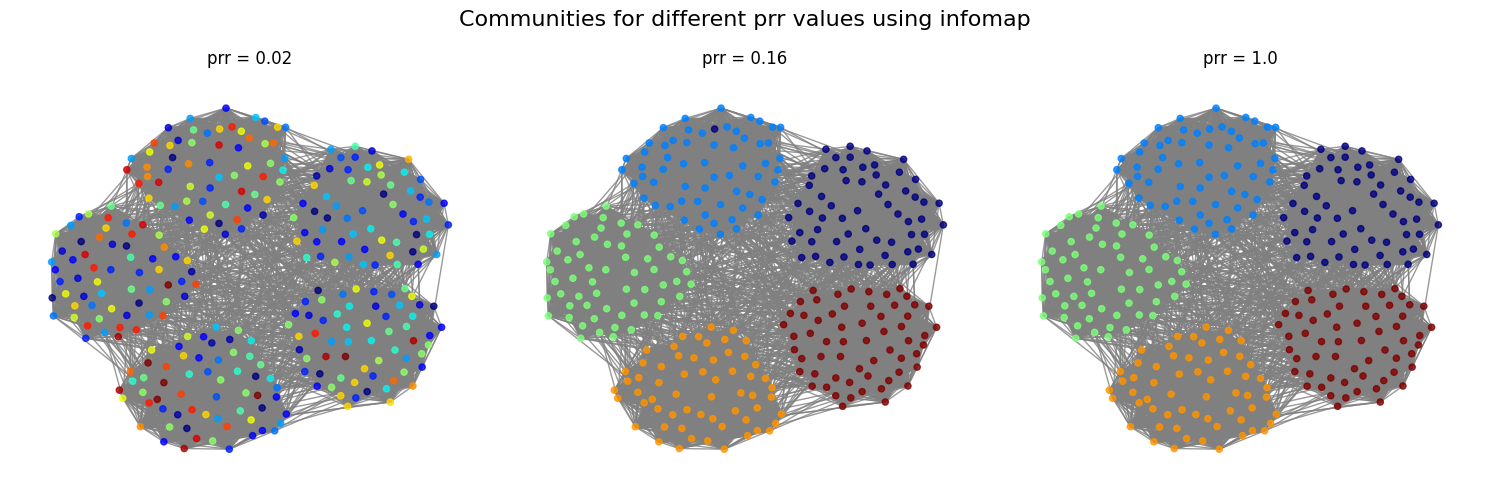

Plotting communities for method: louvain


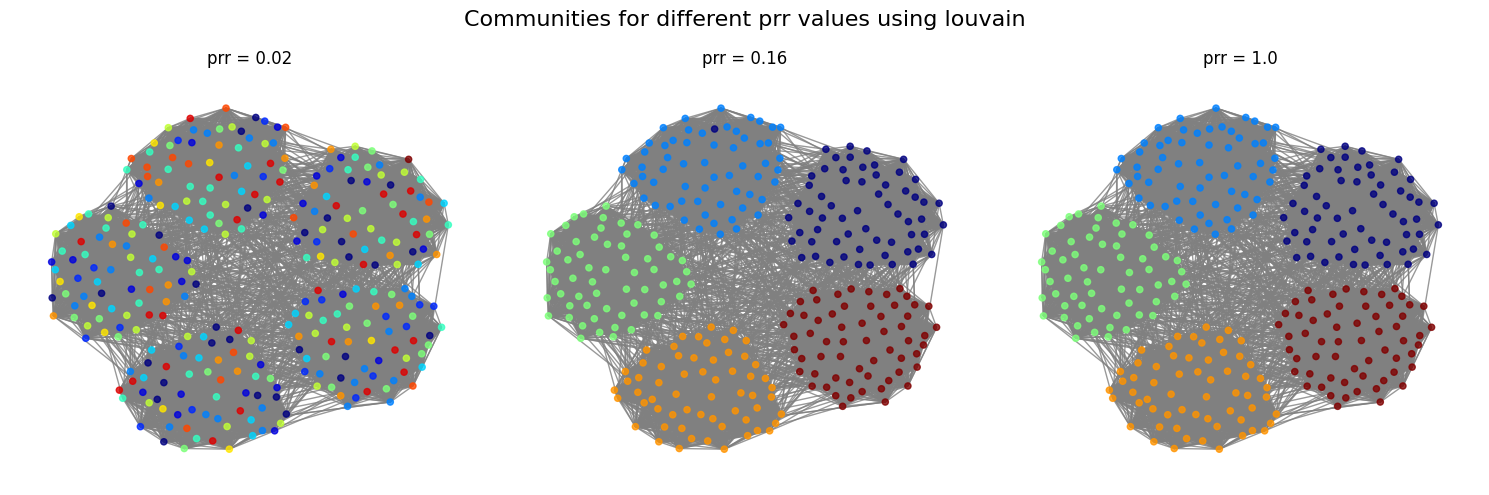

In [20]:
# Load all methods and prr values
communities_dict = load_communities_from_files(folder="SBM")

# Get positions using prr=1 for all methods
G = create_sbm_graph(N, nblocks, 1, prs, seed=SEED, save_pajek=False)
positions = nx.kamada_kawai_layout(G)

# Plot for each method
for method, prr_communities in communities_dict.items():
    print(f"Plotting communities for method: {method}")
    plot_prr_comparison(G, prr_communities, positions, method=method)

We define the evaluation functions to compute the metrics

In [ ]:
from utils import evaluate_partition

evaluate_partition(communities["golden_standard"], communities["infomap"], G, prr)

{'prr': 0.16,
 'num_communities': 5,
 'modularity': 0.46221585491157124,
 'normalized_mutual_information': 0.9894489329632018,
 'normalized_variation_of_information': 0.005954292360321595,
 'jaccard_index': 0.9866442199775534}

Now we are going to plot each of the error metrics with respect to prr

In [27]:
from matplotlib import pyplot as plt
import pandas as pd
from utils import write_pajek_communities


def compute_and_save_communities(step=0.05, folder="SBM"):
    """
    Iterates over prr values from 0 to 1 and, for each value:
      - Generates an SBM graph.
      - Computes communities using various algorithms.
      - Saves each community partition into a Pajek (.clu) file.

    The file names are based on the algorithm used and the prr value.
    Files are stored in the specified folder (default "SBM").
    
    Arguments:
        step (float): Step size for prr (default is 0.05).
        folder (str): Folder path where community files will be saved.
    
    Returns:
        None.
    """
    # Create folder if it does not exist
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    # Iterate over prr values from 0 to 1 (inclusive)
    for prr in np.arange(0, 1 + step, step):
        # Generate the SBM graph for the current prr value.
        G = create_sbm_graph(N, nblocks, prr, prs, seed=SEED, save_pajek=False)
        
        # Compute communities using different algorithms.
        communities = get_all_communities_parallel(G, block_size, nblocks, silent_infomap=True)
        
        # Save each computed community partition into a Pajek (.clu) file.
        # Files are named as: "{method}_prrXX.XX.clu" in the given folder.
        for method, community in communities.items():
            outfile = os.path.join(folder, f"{method}_prr{prr:.2f}.clu")
            write_pajek_communities(community, outfile)
            print(f"Saved {method} community for prr={prr:.2f} to {outfile}")


def compute_and_save_metrics(step=0.05, folder="SBM", csv_filename="metrics.csv"):
    """
    Reads the community partitions saved in the specified folder for each prr value,
    re-generates the corresponding SBM graph, evaluates each partition (except for
    the golden standard) against the golden standard partition, and saves the metrics
    for each evaluation into a CSV file.
    
    The expected file naming is: "{method}_prrXX.XX.clu" for each partition.
    
    Arguments:
        step (float): Step size for prr (default is 0.05).
        folder (str): Folder path where community files are stored (default "SBM").
        csv_filename (str): Name of the CSV file to save evaluation metrics.
    
    Returns:
        None.
    """
    results = []
    
    # Loop over the same set of prr values
    for prr in np.arange(0, 1 + step, step):
        # Gather all community files for the current prr
        # Expected pattern: "{method}_prrXX.XX.clu"
        pattern = f"prr{prr:.2f}.clu"
        community_files = [f for f in os.listdir(folder) if f.endswith(pattern)]
        
        communities = {}
        # Load each community from file
        for filename in community_files:
            method = filename.split("_prr")[0]  # Extract method name from filename
            filepath = os.path.join(folder, filename)
            community = read_pajek_communities(filepath)
            communities[method] = community
        
        # Ensure that the golden standard partition is available for metrics comparisons.
        if "golden_standard" not in communities:
            raise ValueError(f"Golden standard partition not found for prr = {prr:.2f}")
        
        golden = communities["golden_standard"]
        
        # Re-generate the SBM graph for the current prr value. Deterministic seed needed.
        G = create_sbm_graph(N, nblocks, prr, prs, seed=SEED, save_pajek=False)
        
        # Evaluate all non-reference partitions against the golden standard.
        for method, community in communities.items():
            if method == "golden_standard":
                continue  # Skip the reference partition
            metrics = evaluate_partition(golden, community, G, prr)
            
            # Record the metrics in a structured dictionary.
            metrics_record = {
                "prr": prr,
                "method": method,
                "normalized_mutual_information": metrics["normalized_mutual_information"],
                "normalized_variation_of_information": metrics["normalized_variation_of_information"],
                "jaccard_index": metrics["jaccard_index"],
                "modularity": metrics["modularity"],
                "num_communities": metrics["num_communities"]
            }
            results.append(metrics_record)

    # Convert the results list to a DataFrame and save it to CSV.
    df_metrics = pd.DataFrame(results)
    df_metrics.to_csv(csv_filename, index=False)
    print(f"Metrics saved to {csv_filename}")

def plot_metrics(csv_filename="metrics.csv"):
    """
    Loads evaluation metrics from a CSV file and plots each metric as a function of prr.
    The function creates separate plots for:
      - Normalized Mutual Information (NMI)
      - Normalized Variation of Information (VI)
      - Jaccard Index
      - Modularity
      - Number of Communities
      
    Each plot shows curves for the different community detection methods.
    
    Arguments:
        csv_filename (str): The CSV file that contains the evaluation metrics.
    
    Returns:
        None. Plots are displayed on screen.
    """
    # Load the metrics CSV into a DataFrame.
    df = pd.read_csv(csv_filename)
    
    # Determine the unique methods (exclude golden_standard as it has no associated metrics).
    methods = df["method"].unique()
    
    # Define information for each metric plot: (column_name, y-axis label, title)
    metrics_info = [
        ("normalized_mutual_information", "Normalized Mutual Information", "NMI vs prr"),
        ("normalized_variation_of_information", "Normalized Variation of Information", "Normalized VI vs prr"),
        ("jaccard_index", "Jaccard Index", "Jaccard Index vs prr"),
        ("modularity", "Modularity", "Modularity vs prr"),
        ("num_communities", "Number of Communities", "Number of Communities vs prr")
    ]
    
    # Create a separate plot for each metric.
    for metric, ylabel, title in metrics_info:
        plt.figure()
        # Plot metric vs prr for each method.
        for method in methods:
            df_method = df[df["method"] == method]
            plt.plot(df_method["prr"], df_method[metric], label=method.title())
        plt.xlabel("prr")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()
def generate_latex_table(prr_values, csv_filename="metrics.csv", output_filename=None):
    """
    Reads a CSV file containing metrics for various community detection methods and
    generates a LaTeX table comparing the performance for the specified prr values.
    
    The CSV file is expected to have the following columns:
        - prr
        - method (e.g., Infomap, Louvain, Greedy, Girvan-Newman)
        - normalized_mutual_information
        - normalized_variation_of_information
        - jaccard_index
        - num_communities

    The resulting table uses a multirow for each prr and displays four metrics:
        - NMI (normalized_mutual_information)
        - VI (normalized_variation_of_information)
        - Jaccard (jaccard_index)
        - # Communities (num_communities)
    
    Arguments:
        prr_values (list of float): List of prr values to include in the table.
        csv_filename (str): Path to the CSV file containing the metrics.
        output_filename (str, optional): If provided, the LaTeX table will be saved to this file.
    
    Returns:
        str: A string containing the LaTeX table.
    """
    # Read the metrics CSV file
    df = pd.read_csv(csv_filename)

    # Define the algorithms (columns) in the desired order:
    algorithms = ["girvan_newmanc"]

    # Map internal metric column names to their LaTeX labels.
    metric_labels = {
        "normalized_mutual_information": "NMI",
        "normalized_variation_of_information": "VI",
        "jaccard_index": "Jaccard",
        "num_communities": "# Communities",
        "modularity": "Modularity"
    }
    # Order in which to output metrics
    metric_order = ["normalized_mutual_information",
                    "normalized_variation_of_information",
                    "jaccard_index",
                    "num_communities"]

    # Begin building the LaTeX table string.
    latex_str = ""
    latex_str += "\\begin{table}[H]\n"
    latex_str += "\\centering\n"
    latex_str += "\\caption{Performance comparison of community detection algorithms at different prr values}\n"
    latex_str += "\\begin{tabular}{|c|l|c|c|c|c|}\n"
    latex_str += "\\hline\n"
    # Create table header row with prr, metric and methods.
    header_methods = " & ".join([f"\\textbf{{{alg}}}" for alg in algorithms])
    latex_str += f"\\textbf{{prr}} & \\textbf{{Metric}} & {header_methods} \\\\\n"
    latex_str += "\\hline\n"
    
    # Process each given prr value
    for prr in prr_values:
        # Filter dataframe for the current prr value
        subset = df[df["prr"] == prr]
        # Check the number of metric rows to span (4 rows for each prr)
        num_rows = len(metric_order)
        first_row = True
        
        # Loop over each metric to create a row in the table.
        for metric in metric_order:
            line = ""
            if first_row:
                # Use multirow to span prr across the 4 rows
                line += f"\\multirow{{{num_rows}}}{{*}}{{{prr}}} & "
                first_row = False
            else:
                line += " & "
            
            # Add the metric label.
            line += f"{metric_labels[metric]} & "
            
            # Retrieve and format the value for each algorithm.
            values = []
            for alg in algorithms:
                # Filter for the current algorithm in the subset.
                row = subset[subset["method"] == alg]
                if not row.empty:
                    # For integer values (number of communities) print without decimals.
                    if metric == "num_communities":
                        value_str = f"{int(row.iloc[0][metric])}"
                    else:
                        value_str = f"{row.iloc[0][metric]:.2f}"
                else:
                    value_str = "-"
                values.append(value_str)
            line += " & ".join(values) + " \\\\\n"
            latex_str += line
        
        # Close the block for the current prr value.
        latex_str += "\\hline\n"

    latex_str += "\\end{tabular}\n"
    latex_str += "\\label{tab:algorithm_comparison}\n"
    latex_str += "\\end{table}\n"
    
    if output_filename:
        with open(output_filename, "w") as f:
            f.write(latex_str)
        print(f"LaTeX table saved to {output_filename}")
    else:
        print(latex_str)
    
    return latex_str





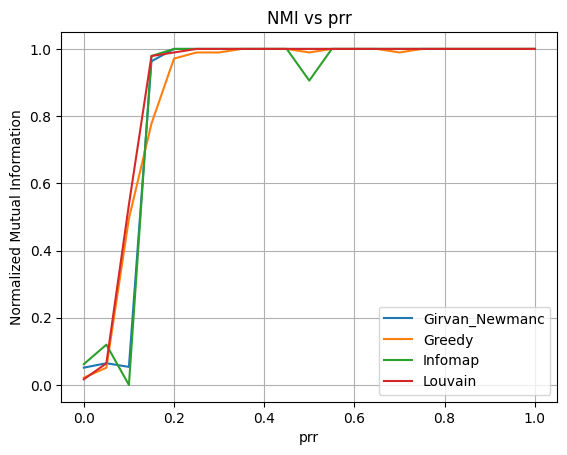

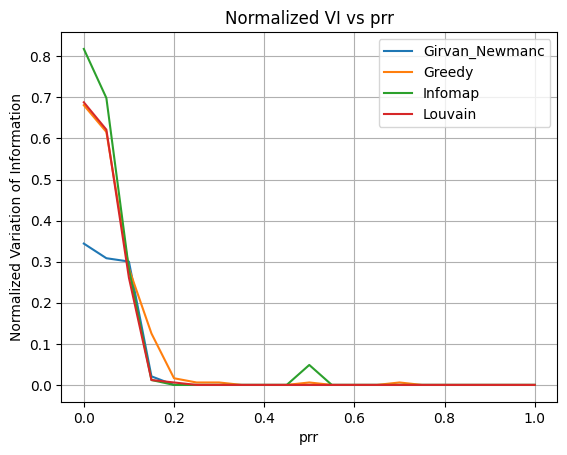

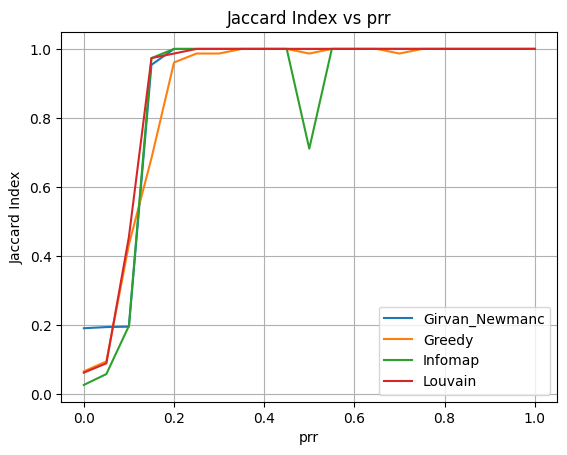

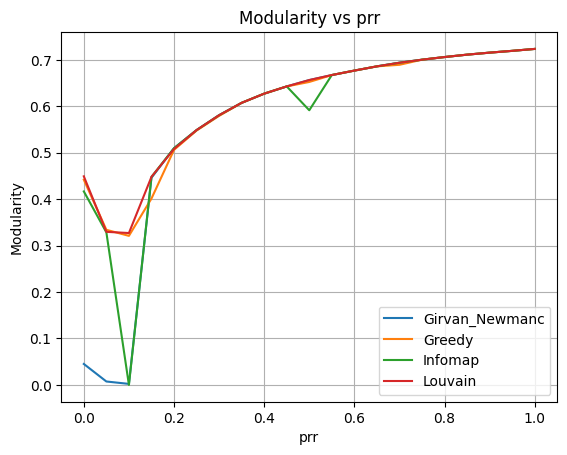

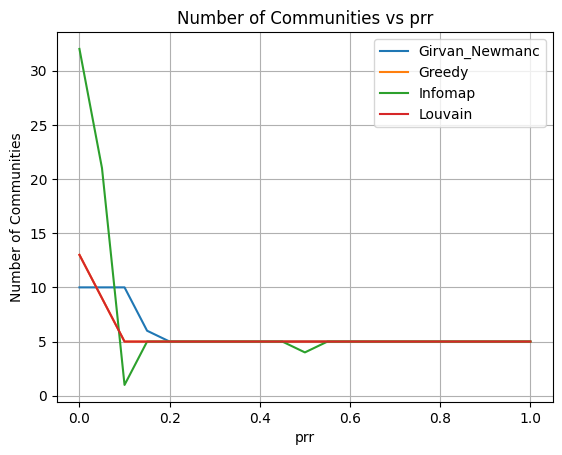

LaTeX table saved to metrics_table.tex


'\\begin{table}[H]\n\\centering\n\\caption{Performance comparison of community detection algorithms at different prr values}\n\\begin{tabular}{|c|l|c|c|c|c|}\n\\hline\n\\textbf{prr} & \\textbf{Metric} & \\textbf{girvan_newmanc} \\\\\n\\hline\n\\multirow{4}{*}{0.1} & NMI & 0.05 \\\\\n & VI & 0.30 \\\\\n & Jaccard & 0.19 \\\\\n & # Communities & 10 \\\\\n\\hline\n\\multirow{4}{*}{0.2} & NMI & 1.00 \\\\\n & VI & 0.00 \\\\\n & Jaccard & 1.00 \\\\\n & # Communities & 5 \\\\\n\\hline\n\\multirow{4}{*}{0.3} & NMI & 1.00 \\\\\n & VI & 0.00 \\\\\n & Jaccard & 1.00 \\\\\n & # Communities & 5 \\\\\n\\hline\n\\multirow{4}{*}{0.4} & NMI & 1.00 \\\\\n & VI & 0.00 \\\\\n & Jaccard & 1.00 \\\\\n & # Communities & 5 \\\\\n\\hline\n\\multirow{4}{*}{0.5} & NMI & 1.00 \\\\\n & VI & 0.00 \\\\\n & Jaccard & 1.00 \\\\\n & # Communities & 5 \\\\\n\\hline\n\\multirow{4}{*}{0.75} & NMI & 1.00 \\\\\n & VI & 0.00 \\\\\n & Jaccard & 1.00 \\\\\n & # Communities & 5 \\\\\n\\hline\n\\multirow{4}{*}{1} & NMI & 1.00 \\

In [29]:
# First, generate and save communities and metrics.
# We comment these line as it is time-consuming and we already have the files.
# compute_and_save_communities()
# compute_and_save_metrics(step=0.05, folder="SBM", csv_filename="metrics.csv")


# Then, load the metrics CSV and plot the results.
plot_metrics(csv_filename="metrics.csv")
generate_latex_table([0.1,0.2,0.3,0.4,0.5,0.75,1], csv_filename="metrics.csv", output_filename="metrics_table.tex")
